In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency
from scipy.stats import zscore
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

# MODELAGEM COM KMeans

In [104]:
dados_clientes = pd.read_csv("C:/Projetos Pessoais/DataScience/segmentacao_Clientes_Ecomerce/data/dados_processados.csv")

In [105]:
dados_clientes.set_index('Cod_cliente', inplace = True)
dados_clientes

,Ultima_Compra,Total_transacoes,Valor_total_gasto,Avg_transacao,Dia_fav_compra,UK,Gastos_medios_mensais,Desvio_padrao_gastos_mensais,Tendencia_gastos
Cod_cliente,,,,,,,,,
12347,-1.020356,0.726574,1.476625,-0.030005,1,0,0.039694,1.269518,0.066020
12348,-0.363187,-0.463910,0.056129,0.281107,3,0,-0.234827,0.553195,-0.571752
12349,-0.876319,-0.118286,0.066171,-0.066223,0,0,0.941013,-0.511282,0.038867
12350,1.752356,-0.548396,-0.508972,-0.085595,2,0,-0.304323,-0.511282,0.038867
12352,-0.714277,-0.079883,0.030663,-0.089806,1,0,-0.248612,0.115483,0.022634
...,...,...,...,...,...,...,...,...,...
21821,-1.029358,-0.655924,-0.652888,-0.261628,3,1,-0.615939,-0.511282,0.038867
21822,-1.029358,4.198178,2.163445,-0.184666,3,1,5.482159,-0.511282,0.038867
21823,-1.038360,4.935510,2.686130,-0.181929,4,1,6.613909,-0.511282,0.038867


# Verificando o número ideal de clusters (K)

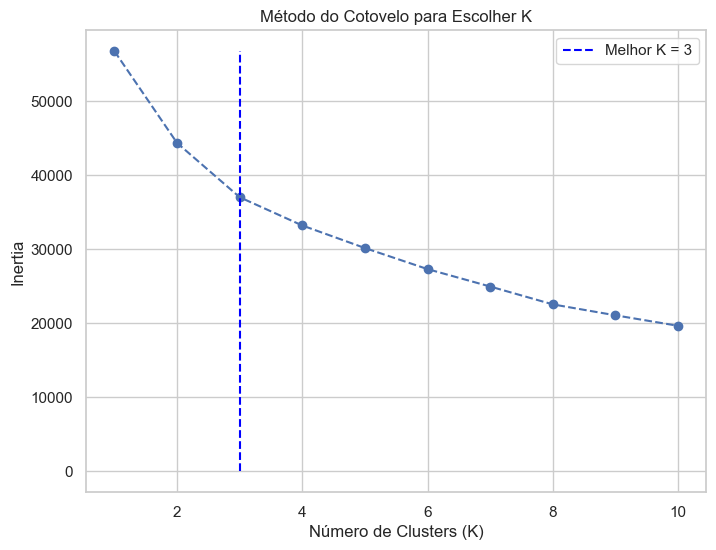

In [106]:
# Utilizando o método cotovelo (curva)
inercia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(dados_clientes)
    inercia.append(kmeans.inertia_)

sns.set(style="whitegrid")

# Plotar o método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inercia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo para Escolher K')

# Melhor K
best_k = 3  # Suponha que o melhor K seja 3
plt.vlines(x=best_k, ymin=0, ymax=max(inertia), colors='blue', linestyles='dashed', label=f'Melhor K = {best_k}')

plt.legend()
plt.show()

- Escolhi K = 3 pois é onde a curva de inercia começa a estabilizar

## Aplicando o algorítmo com K = 3

In [107]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
clusters = kmeans.fit_predict(dados_clientes)

In [108]:
# Criando a variável 'Cluster', para identificação de cada cluster
dados_clientes['Cluster'] = clusters

In [109]:
dados_clientes

,Ultima_Compra,Total_transacoes,Valor_total_gasto,Avg_transacao,Dia_fav_compra,UK,Gastos_medios_mensais,Desvio_padrao_gastos_mensais,Tendencia_gastos,Cluster
Cod_cliente,,,,,,,,,,
12347,-1.020356,0.726574,1.476625,-0.030005,1,0,0.039694,1.269518,0.066020,2
12348,-0.363187,-0.463910,0.056129,0.281107,3,0,-0.234827,0.553195,-0.571752,1
12349,-0.876319,-0.118286,0.066171,-0.066223,0,0,0.941013,-0.511282,0.038867,0
12350,1.752356,-0.548396,-0.508972,-0.085595,2,0,-0.304323,-0.511282,0.038867,0
12352,-0.714277,-0.079883,0.030663,-0.089806,1,0,-0.248612,0.115483,0.022634,0
...,...,...,...,...,...,...,...,...,...,...
21821,-1.029358,-0.655924,-0.652888,-0.261628,3,1,-0.615939,-0.511282,0.038867,1
21822,-1.029358,4.198178,2.163445,-0.184666,3,1,5.482159,-0.511282,0.038867,2
21823,-1.038360,4.935510,2.686130,-0.181929,4,1,6.613909,-0.511282,0.038867,2


In [137]:
dados_clientes.shape

(5510, 10)

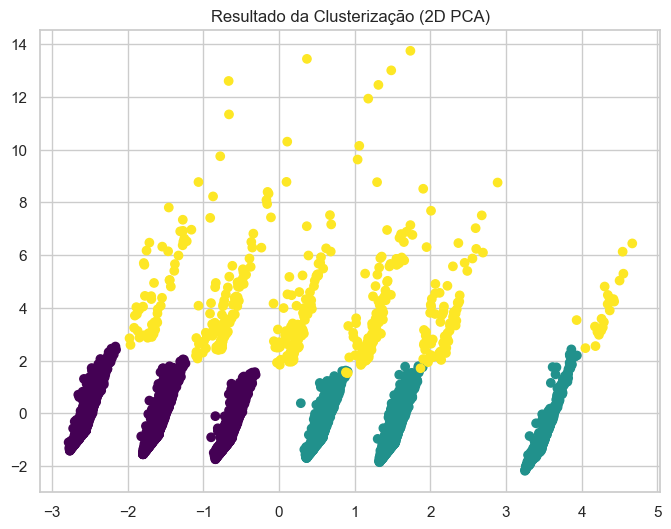

In [110]:
# Visualização da distribuição dos clusters

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(dados_clientes)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Resultado da Clusterização (2D PCA)')
plt.show()

In [115]:
# Quantidade de clientes por cluster
df_cluster = dados_clientes['Cluster'].value_counts().reset_index()

# Criação da variável Porcentagem
df_cluster['Porcentagem (%)'] = round((df_cluster['count'] / df_cluster['count'].sum()) * 100, 2)
df_cluster = df_cluster.drop(columns = ['count'])
df_cluster

,Cluster,Porcentagem (%)
0,0,47.64
1,1,43.12
2,2,9.24


In [116]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cluster          3 non-null      int32  
 1   Porcentagem (%)  3 non-null      float64
dtypes: float64(1), int32(1)
memory usage: 164.0 bytes


In [117]:
# Renomeando Cluster
def renomeia_cluster(x):
    if x == 0:
        return 'Cluster 0'
    elif x == 1:
        return 'Cluster 1'
    elif x == 2:
        return 'Cluster 2'
    
df_cluster['Cluster'] = df_cluster['Cluster'].map(renomeia_cluster)
df_cluster

,Cluster,Porcentagem (%)
0,Cluster 0,47.64
1,Cluster 1,43.12
2,Cluster 2,9.24


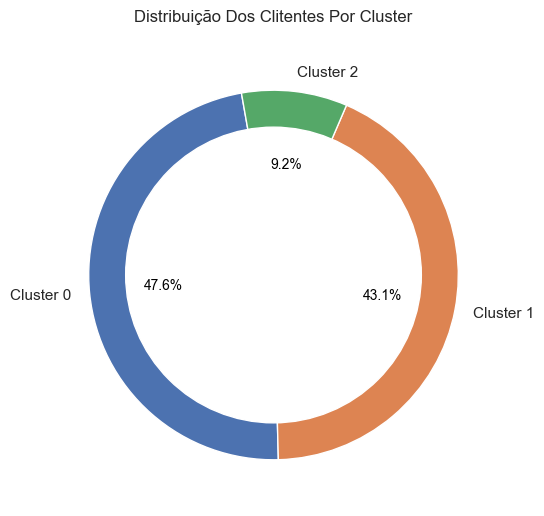

In [119]:
plt.figure(figsize=(12, 6))

# Desenhar o gráfico de pizza com as quantidades
wedges, texts, autotexts = plt.pie(df_cluster['Porcentagem (%)'], labels=df_cluster['Cluster'],
                                   autopct='%1.1f%%', startangle=100)
# Configurar as propriedades dos textos
plt.setp(autotexts, size=10, color='black')

centre_circle = plt.Circle((0, 0), 0.8, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribuição Dos Clitentes Por Cluster', y=1.03)
plt.show()

## Avaliando Métricas

In [124]:
# Métricas
sil_score = silhouette_score(data_pca, clusters)
calinski_score = calinski_harabasz_score(data_pca, clusters)
davies_score = davies_bouldin_score(data_pca, clusters)

# Dataframe para visualização das métricas
df_metricas = pd.DataFrame({
    "Métricas": ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"],
    "Valor": [sil_score, calinski_score, davies_score]
})


df_metricas

,Métricas,Valor
0,Silhouette Score,0.496276
1,Calinski Harabasz Score,5325.107721
2,Davies Bouldin Score,0.725668


- **Silhouette Score**: O Silhouette Score varia de -1 a 1. Valores próximos a 1 indicam que os clusters estão bem separados, enquanto valores próximos a -1 sugerem que as instâncias foram atribuídas aos clusters errados. No seu caso, um valor de 0.496 é relativamente alto e sugere que os clusters têm uma boa separação.

- **Calinski Harabasz Score**: O Calinski Harabasz Score é uma métrica que avalia a dispersão entre e dentro dos clusters. Quanto maior o valor, melhor definidos são os clusters. Um valor de 5325.11 é considerado alto e sugere que os clusters estão bem definidos.

- **Davies Bouldin Score**: O Davies Bouldin Score avalia a média da similaridade entre cada cluster e seu cluster mais semelhante. Valores menores indicam melhor separação entre os clusters. Um valor de 0.7257 é geralmente considerado razoável.

### No geral, o modelo teve um ótimo resultado

In [136]:
# Salvando DF para a etapa de geração de insights 
dados_clientes.to_csv('../data/dados_clientes_clusterizados.csv', sep =',', index = True, encoding = 'utf-8')